# The Coupled Criterion

Author: Sara Jiménez Alfaro (sara.jimenez_alfaro@sorbonne-universite.fr)

The Coupled Criterion allows predicting crack nucleation in brittle materials. It has been successfully applied in several problems at the macroscale, such as notched specimens, laminates, adhesive joints or embedded inclusions [1]. This criterion is corroborated by previous experiments on transverse cracking in cross-ply laminates [2]. According to the CC, two necessary conditions are together sufficient to predict the crack nucleation [3], since fracture occurs when both are simultaneously fulfilled: (i) an energy condition, based on an energy balance, 

$$ \bar{G}_{\text{inc}} = \frac{G_{\text{inc}} (\delta l)}{G_{\text{c}}} \geq 1 $$

and (ii) a stress condition, that can be expressed either as a non-local condition, 

$$ \bar{\sigma} = \frac{\sigma (s)}{ \sigma_{\text{c}}} \geq 1 $$ 

or using the so-called Point Method [1], 

$$ \bar{\sigma} = \frac{\sigma (\delta l)}{ \sigma_{\text{c}}} \geq 1 $$

or using the Line Method [4], 

$$ \bar{\sigma} = \frac{1}{\sigma_\text{c} \delta l}\int_0^{\delta l} \sigma (z) dz\geq 1 $$ 

Two different methodologies can be used to estimate the elastic solution that will be used to apply the CC: the Matched Asymptotics Approach and the Full Finite Element Approach. In the latter the whole structure under consideration is modelled by FE either under a prescribed displacement or a prescribed force. In a first step an undamaged configuration is considered, i.e. with no new crack in the structure. The tensile stress $\sigma (s)$ along the expected crack path is computed together with the potential energy $ W_{\text{0}}$ . Then, the nodes along the expected crack path are released one after the other, generating a virtual crack with increasing length $\delta l$ and allowing the computation of  $ W (\delta l)$ and then $G_{\text{inc}}(\delta l)$ . Notice that several calculations are required to build the function $G_{\text{inc}}(\delta l)$ in the FFE approach. In the following example the procedure will be shown. 

Let's consider a double-notched nano-tablets of aragonite. The solution to this problem was initially estimated in [5] using Phase Field model and Molecular Dynamics simulations. Then, in [6] it was numerically solved applying the CC on an equivalent 2D model. The reported material properties for aragonite in [5] are $E = 126$ GPa, $\nu=0.44$, $G_\text{c} = 2.091$ J $\text{m}^{-2}$. In [6] the Young modulus was readjusted to $E = 96$ GPa to have a similar global stiffness and the value of $\sigma_\text{c}$ was adjusted to $5$ GPa to have a good agreement with results reported in [5]. As it is shown in Figure 1, symmetry can be applied and the problem is solved in just 1/2 of the whole specimen. Only horizontal symmetry would be applied since the elastic solution along the complete line $y=0, x=[0, H

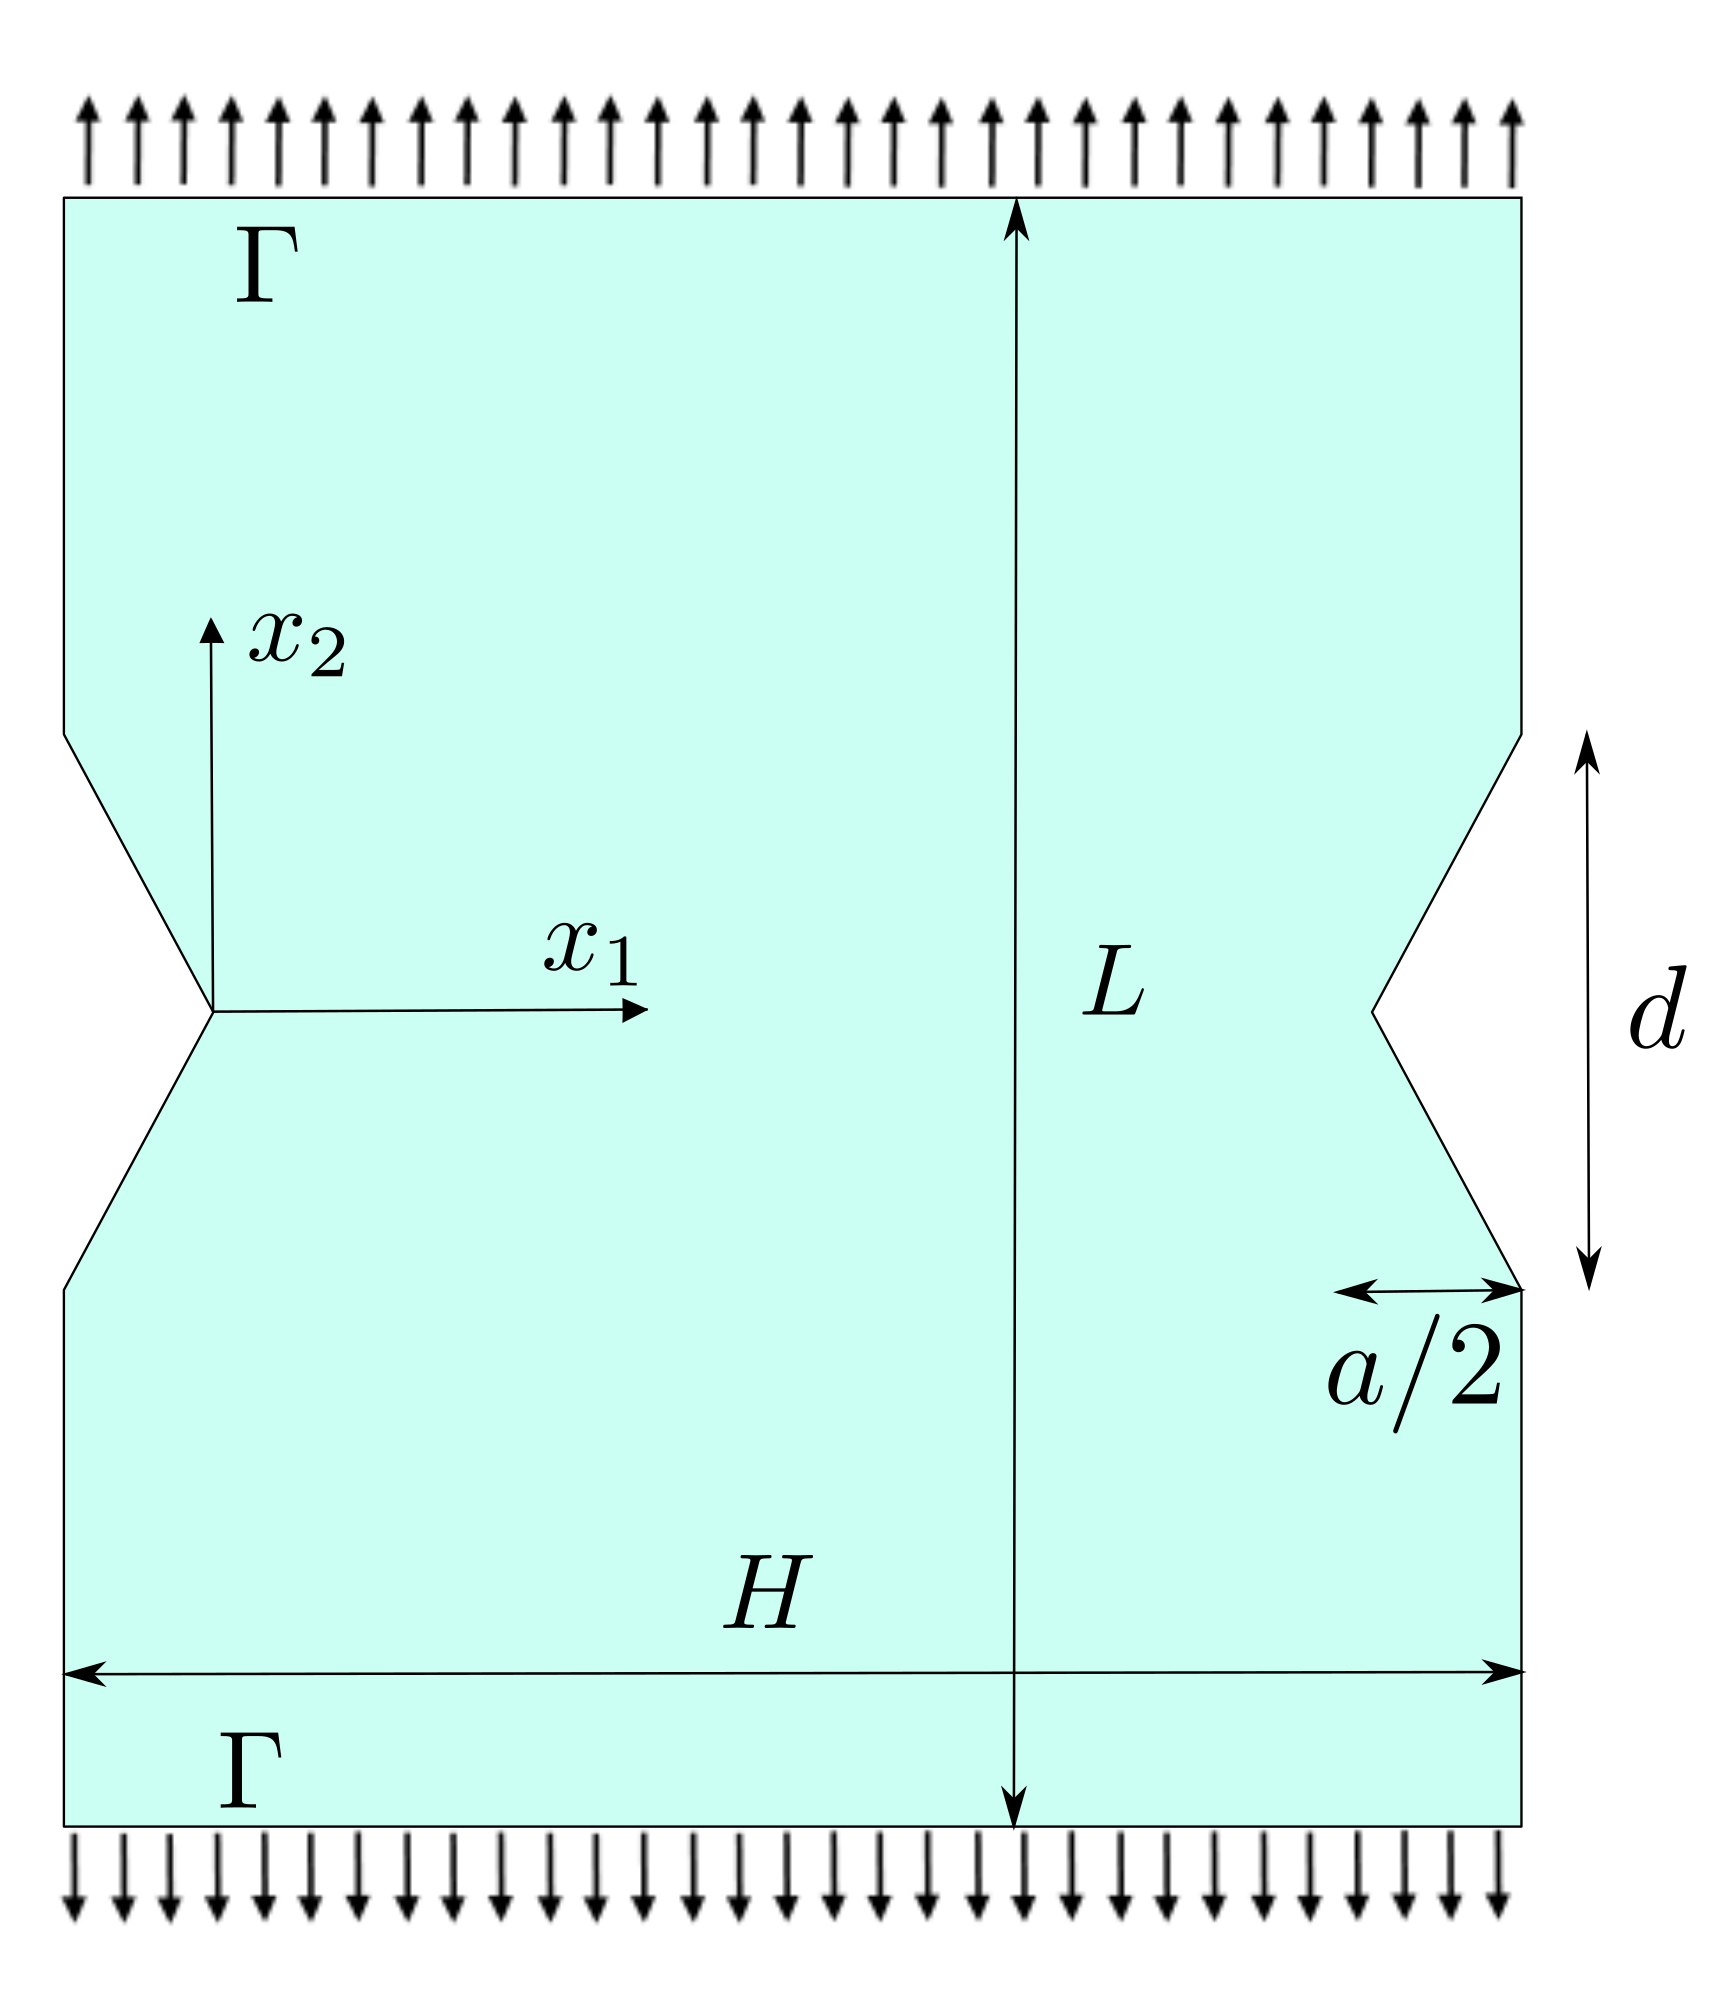
<figcaption align = "center"> Figure 1: Representation of the double-notched nano-tablets of aragonite </figcaption>

The results were compared in [6] with numerical results obtained using phase field and molecular dynamics in [5]. A good agreement is found, as it is shown in Figure 2. 

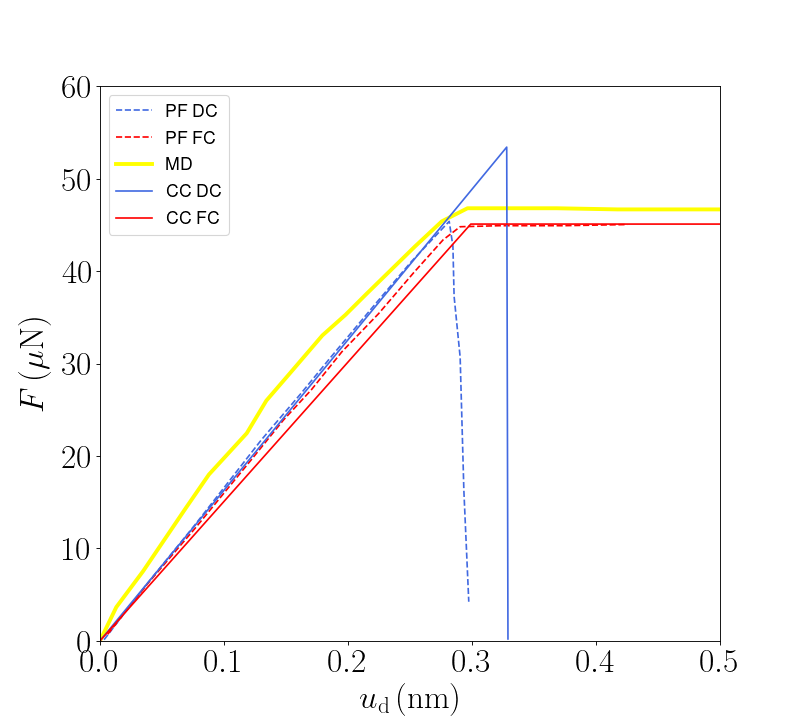
<figcaption align = "center"> Figure 2: Comparison between results obtained in the Coupled Criterion and other methodologies for DC and FC </figcaption>

[1] Weißgraeber, P., Leguillon, D., & Becker, W. (2016). A review of Finite Fracture Mechanics: crack initiation at singular and non-singular stress raisers. Archive of Applied Mechanics, 86, 375-401.

[2] Parvizi, A., Garrett, K. W., & Bailey, J. E. (1978). Constrained cracking in glass fibre-reinforced epoxy cross-ply laminates. Journal of Materials Science, 13, 195-201.

[3] Leguillon, D. (2002). Strength or toughness? A criterion for crack onset at a notch. European Journal of Mechanics-A/Solids, 21(1), 61-72.

[4] Cornetti, P., Pugno, N., Carpinteri, A., & Taylor, D. (2006). Finite fracture mechanics: a coupled stress and energy failure criterion. Engineering Fracture Mechanics, 73(14), 2021-2033.

[5] Patil, S. P., Heider, Y., Padilla, C. A. H., Cruz-Chú, E. R., & Markert, B. (2016). A comparative molecular dynamics-phase-field modeling approach to brittle fracture. Computer Methods in Applied Mechanics and Engineering, 312, 117-129.

[6] Jiménez-Alfaro, S., & Leguillon, D. (2021). Finite Fracture Mechanics at the micro-scale. Application to bending tests of micro cantilever beams. Engineering Fracture Mechanics, 258, 108012.

# Step 0: Definition of the problem

Import the required libraries

In [1]:
import numpy as np
import dolfinx
import ufl
from petsc4py import PETSc
import sys
sys.path.append("./pycodes_coupledcriterion")

In [2]:
#............ Extra codes in the folder pycodes_coupledcriterion
from fem_solver import fem_solver
from plot_results import plot_stresses, plot_ginc
from mesh_patil import generate_mesh
from plot_results import init_pyvista, plot_mesh
from coupled_criterion import coupled_criterion

Definition of the parameters: Geometrical inputs in the problem are given in [nm], the Young modulus and tensile strength in [GPa], and the critical energy release rate in [GPa nm]

In [3]:
Geometrical_data = {'L':15.3, 'H':11.2, 'd':3.08, 'a':1.84, 'e':4.30}
Mechanical_data  = {'E':96, 'nu':0.44, 'Sc':5., 'Gc': 2.091, 'control':'DC'} # control can be 'DC' = Displacement control or 'FC' = force control
Mesh_data        = {'m0':0.03, 'm1':0.04, 'm2':0.8}

Generation of the mesh with Gmsh and importation in the dolfinx format

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.0078417s, CPU 0.008934s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.112809s, CPU 0.112723s)
Info    : 5275 nodes 10554 elements


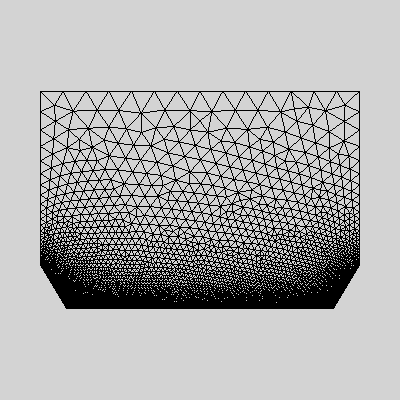

In [4]:
# .............. Mesh generation ..........................
mesh, facets = generate_mesh(Geometrical_data, Mesh_data)  

import ufl

PYVISTA_ON = True
if PYVISTA_ON:
    init_pyvista()
    plot_mesh(mesh)

# Step 1: Solution in the undamaged configuration 
In a first step, the calculation is done in the undamaged configuration (no crack). We obtain the tensile stress $\sigma_{yy} (x) $ and the elastic energy in the initial configuration $W_0$. We consider a unitary displacement $\rho = 1$ (displacement control). Then, if the option force control is selected, the corresponding postprocess will be applied. 

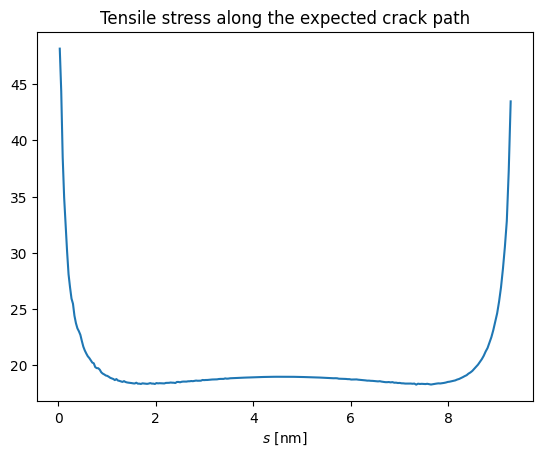

<Figure size 640x480 with 0 Axes>

In [5]:
# .............. Solution in the undamaged configuration (displacement control)  ..........................
W0, P0, sig, dl = fem_solver(mesh, facets, Mechanical_data, Geometrical_data, 0)
# .............. Postprocessing in case of force control
if Mechanical_data.get('control')=='FC':
    sig = sig * 1 / P0
    W0  = W0 / P0**2
# ............. Representation of the tensile stress along the expected crack path
plot_stresses(dl,sig)

# Step 2: release the nodes one by one and calculate the $G_\text{inc}$

In this case we change the homogeneous Neumann boundary condition that defines the crack, by changing $dl$ progressively. 

In [6]:
# ........................ Calculation of the elastic energy and the force for each node released (displacement control)
W, P = np.zeros(len(dl)), np.zeros(len(dl))
for j in range(0,len(dl)):
    W[j], P[j] = fem_solver(mesh, facets, Mechanical_data, Geometrical_data, dl[j])

We calculate the energy release rate. 

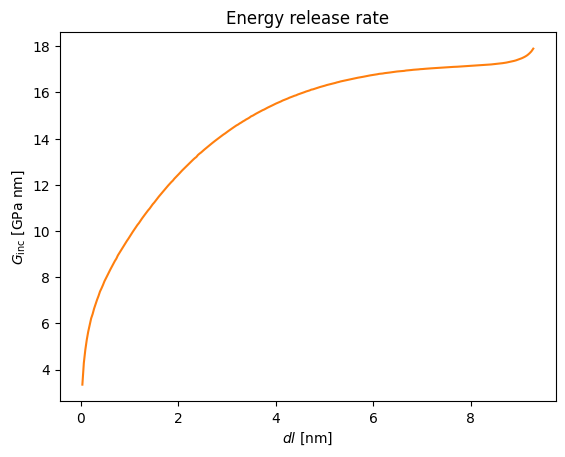

<Figure size 640x480 with 0 Axes>

In [7]:
# ........................ Calculation of the energy release rate (Ginc)
if Mechanical_data.get('control')=="DC":
    Ginc = np.divide((W0*np.ones(len(dl)) - W),dl)
else:
    W    = np.divide(W,np.inner(P,P))
    Ginc = np.divide((W - W0*np.ones(len(dl))),dl)
# ............. Representation of the energy release rate along the expected crack path
plot_ginc(dl,Ginc)

# Step 3 : Automatization code of the Coupled Criterion
This code works for most of the cases that can be solved using the Coupled Criterion, considering an homogeneous material.

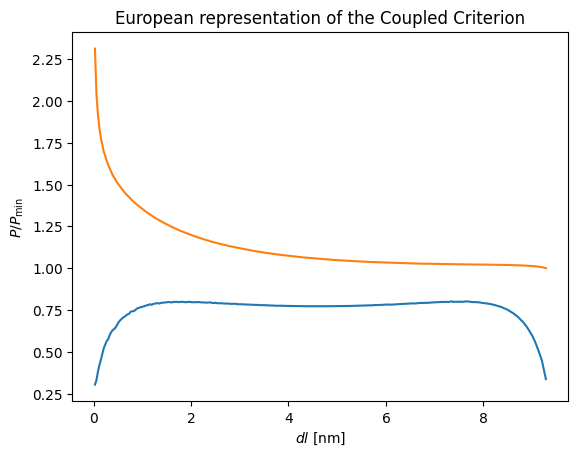

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

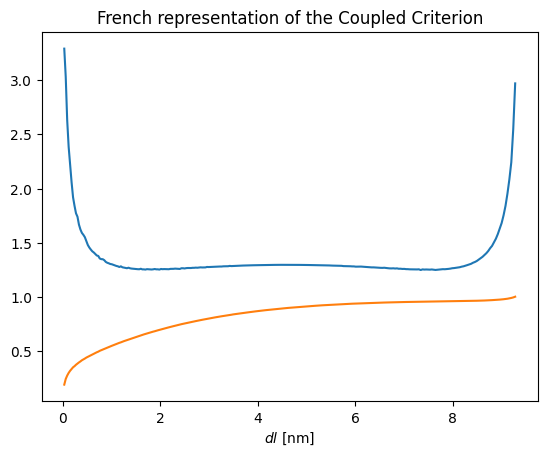

The critical displacement is [[0.34183517]]


<Figure size 640x480 with 0 Axes>

In [8]:
# .............   Automatization of the Coupled Criterion
P = coupled_criterion(sig,Ginc,dl,Mechanical_data.get('Sc'),Mechanical_data.get('Gc'))
if Mechanical_data.get('control')=='DC':
    print('The critical displacement is', P)
else:
    print('The critical force is', P)